# Neural Style Transfer

Neural Style Transfer (NST) merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S. 

<img src="images/louvre_generated.png" style="width:750px;height:200px;">

## Librarys

In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint

%matplotlib inline

In [4]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='utils/nst_utils/pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

<Functional name=vgg19, built=True>


## Algorithm

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. Exciting!


### Content Cost

#### Make Generated Image G Match the Content of Image C

One goal you should aim for when performing NST is for the content in generated image G to match the content of image C. To do so, you'll need an understanding of <b> shallow versus deep layers </b>:

* The shallower layers of a ConvNet tend to detect lower-level features such as <i>edges and simple textures</i>.
* The deeper layers tend to detect higher-level features such as more <i> complex textures and object classes</i>. 

#### To choose a "middle" activation layer $a^{[l]}$ :
You need the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you will usually get the most visually pleasing results if you choose a layer from somewhere in the middle of the network--neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.
* After you have finished this exercise, feel free to come back and experiment with using different layers to see how the results vary!

#### To forward propagate image "C:"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, this was written as $a^{[l](C)}$, but here the superscript $[l]$ is dropped to simplify the notation.) This will be an $n_H \times n_W \times n_C$ tensor.

#### To forward propagate image "G":
* Repeat this process with the image G: Set G as the input, and run forward propagation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

In this running example, the content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


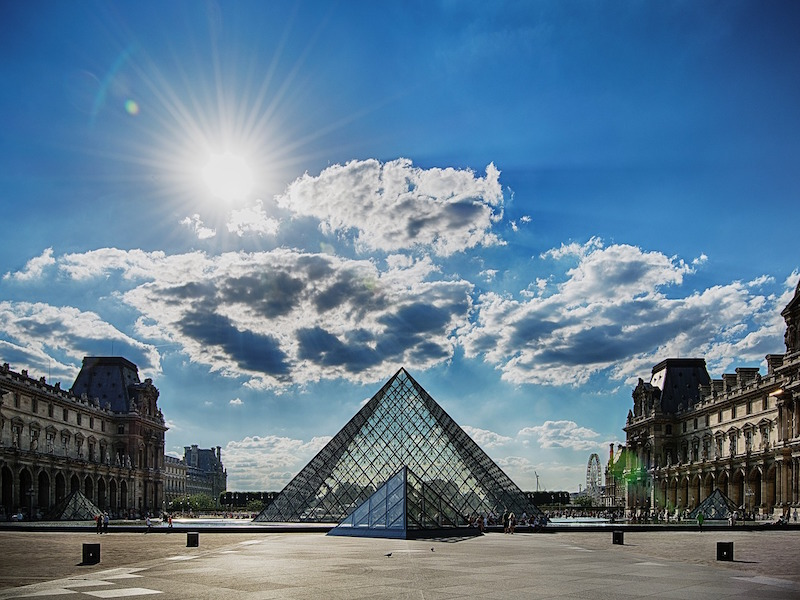

In [6]:
content_image = Image.open("../datasets/art/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

In [ ]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
       
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape 'a_C' and 'a_G'
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])
    
    # compute the cost with tensorflow
    J_content = 1 / (4 * n_H * n_W * n_C) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    return J_content